Data source: https://www.science.org/doi/10.1126/sciadv.aba1983

In [1]:
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.stats import ranksums
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import hypergeom, ttest_ind
from gene_sets import SncGeneSets
import matplotlib.pyplot as plt
import gseapy as gp
from os.path import expanduser
import peasy as ps
from utils import pqvals
from pathlib import Path
from tqdm.auto import tqdm

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

colony = ps.Colony()
artist = colony.new_artist()

In [2]:
root = Path('figures/IPF')
root.mkdir(exist_ok=True)

In [3]:
pal = ["33658a","86bbd8","758e4f","f6ae2d","f26419"]
pal = [f'#{v}' for v in pal]
gene_set_to_color = {
    "GO": pal[0],
    "Fridman": pal[1],
    "SenMayo": pal[2],
    "CellAge": pal[3],
    "SenSet": pal[4],
}

In [4]:
SNC = SncGeneSets(SenSet='SenSet.txt')
gene_sets = {
    'GO': SNC.GO,
    'Fridman': SNC.Fridman,
    'SenMayo': SNC.SenMayo,
    'CellAge': SNC.CellAge,
    'SenSet': SNC.SenSet,
}
SNC

Gene Set module with keys:
	GO: 83
	Fridman: 90
	SenMayo: 125
	CellAge: 279
	union: 501
	SenSet: 106

In [5]:
# shape (312928, 45947)
ipf = anndata.read_h5ad(expanduser('~/data/CompBio/IPF-GSE136831/IPF.h5ad'))

In [6]:
sc.pp.filter_genes(ipf, min_cells=50)
sc.pp.filter_cells(ipf, min_genes=100)

In [7]:
ipf

AnnData object with n_obs × n_vars = 312928 × 33435
    obs: 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'n_genes'
    var: 'HGNC_EnsemblAlt_GeneID', 'n_cells'

In [8]:
ipf.obs['Disease_Identity'].value_counts()

Disease_Identity
IPF        147169
Control     96303
COPD        69456
Name: count, dtype: int64

In [9]:
sc.pp.log1p(ipf)

In [10]:
def ipf_vs_controls(ipf, cell_type, gene_sets):
    """Run enrichr for IPF vs controls for this cell type"""
    cell_type_ctrl = ipf[
        (ipf.obs['Manuscript_Identity'] == cell_type)
        & (ipf.obs['Disease_Identity'] == 'Control')
    ]

    cell_type_ipf = ipf[
        (ipf.obs['Manuscript_Identity'] == cell_type)
        & (ipf.obs['Disease_Identity'] == 'IPF')
    ]

    if len(cell_type_ctrl) < 30 or len(cell_type_ipf) < 30:
        print(f"Skipping {cell_type}")
        return None

    ctrl_mean = np.asarray(cell_type_ctrl.X.mean(0)).ravel()
    ipf_mean = np.asarray(cell_type_ipf.X.mean(0)).ravel()

    log_fc = ipf_mean - ctrl_mean

    gene_sets = {gs: getattr(SNC, gs) for gs in gene_sets}

    genes = pd.DataFrame(index=ipf.var['HGNC_EnsemblAlt_GeneID'].astype(str), data={'Rank': log_fc})
    enr = gp.prerank(genes, gene_sets=gene_sets, outdir=None)
    res = enr.res2d
    res['Cell Type'] = cell_type
    res['Disease'] = 'IPF'
    return res

In [ ]:
cell_type_to_res = []

for cell_type in tqdm(ipf.obs['Manuscript_Identity'].unique()):
    res = ipf_vs_controls(ipf, cell_type, gene_sets=SNC.gene_sets)
    if res is not None:
        cell_type_to_res.append(res)

cell_type_to_res = pd.concat(cell_type_to_res, ignore_index=True)

In [53]:
cell_type_to_res[r'% Genes in set'] = cell_type_to_res['Tag %'].map(lambda x: eval(x)) * 100

In [12]:
# cell_type_to_res['neg(NES)'] = -cell_type_to_res['NES']
cell_type_to_res.sort_values(['FDR q-val'], inplace=True, ignore_index=True)

In [44]:
cell_type_to_res[r'$\log_{10}\frac{1}{FDR}$'] = -np.log10(np.clip(cell_type_to_res['FDR q-val'].astype(float), 1e-15, None))

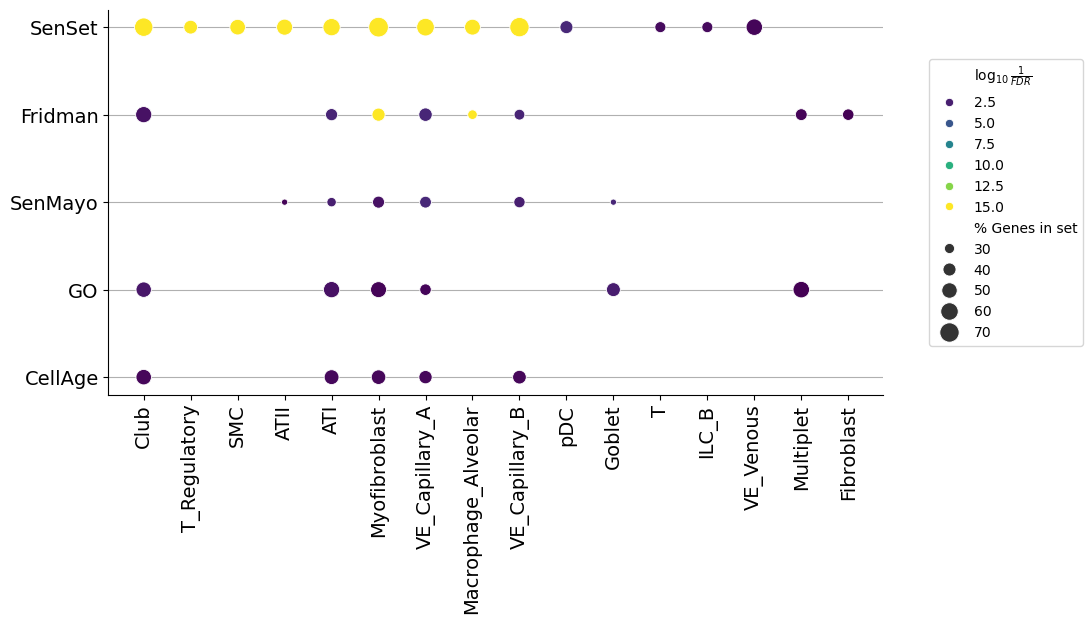

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    cell_type_to_res[cell_type_to_res['FDR q-val'] <= 0.05],
    x="Cell Type",
    y="Term",
    size=r'% Genes in set',
    hue=r'$\log_{10}\frac{1}{FDR}$',
    palette='viridis',
    sizes=(20, 200),
    ax=ax,
)

sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
colony.correct_font_size(ax)
sns.despine(ax=ax)
ax.grid(axis='y')

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)

artist.savefig(root / f"Cell-Type-Analysis.pdf")

In [13]:
cell_type_to_res

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,Cell Type,Disease
0,prerank,SenSet,0.781613,1.282488,0.0,0.0,0.0,65/100,12.75%,TMSB4X;CD9;B2M;GSN;CTNNB1;FOS;VIM;LMNA;S100A11...,Club,IPF
1,prerank,SenSet,0.802328,1.552052,0.0,0.0,0.0,43/100,7.08%,TMSB4X;B2M;VIM;IL32;FOS;ZFP36;TNFAIP3;IL6ST;SO...,T_Regulatory,IPF
2,prerank,SenSet,0.748333,1.537033,0.0,0.0,0.0,51/100,8.05%,JUN;IGFBP4;LMNA;FOS;ZFP36;TMSB4X;B2M;VIM;RHOB;...,SMC,IPF
3,prerank,SenSet,-0.82845,-1.423156,0.0,0.0,0.0,53/100,5.99%,CXCL2;CXCL8;ZFP36;IL6ST;NPM1;CD44;S100A11;JUN;...,ATII,IPF
4,prerank,SenSet,0.828212,1.271216,0.0,0.0,0.0,59/100,7.98%,B2M;AREG;LMNA;CTNNB1;TMSB4X;IL32;ASPH;TXN;IGFB...,ATI,IPF
...,...,...,...,...,...,...,...,...,...,...,...,...
165,prerank,SenSet,0.51011,1.080699,0.343396,1.0,0.542,27/100,4.64%,TMSB4X;B2M;FOS;JUN;ZFP36;TXNIP;IFI16;IL32;VIM;...,NK,IPF
166,prerank,GO,0.546467,1.088826,0.341407,1.0,0.76,34/78,17.61%,LMNA;B2M;ID2;SMC5;PLA2R1;NSMCE2;YBX1;ABL1;MAP2...,Lymphatic,IPF
167,prerank,Fridman,0.478881,0.966004,0.562212,1.0,0.94,29/84,12.27%,ID1;FN1;VIM;RHOB;IGFBP4;SPARC;CCND1;ALDH1A1;SM...,Lymphatic,IPF
168,prerank,SenSet,0.521051,1.12322,0.275216,1.0,0.593,34/100,5.92%,VIM;FOS;TMSB4X;CD44;TXNIP;IL6ST;IL32;B2M;GSN;N...,DC_Mature,IPF


In [ ]:
cell_type_to_res = []

for cell_type in tqdm(ipf.obs['Manuscript_Identity'].unique()):
    res = ipf_vs_controls(ipf, cell_type, gene_sets=['SenSet', 'SenMayo'])
    if res is not None:
        cell_type_to_res.append(res)

cell_type_to_res_ss = pd.concat(cell_type_to_res, ignore_index=True)

In [64]:
cell_type_to_res_ss = cell_type_to_res[cell_type_to_res['Term'].isin(['SenSet', 'SenMayo'])].copy()

In [68]:
cell_type_to_res_ss['-log(FDR)'] = -np.log10(cell_type_to_res_ss['FDR q-val'].astype(float))
cell_type_to_res_ss['Is significant'] = np.where(cell_type_to_res_ss['FDR q-val'] <= 0.05, 'Yes', 'No')

/var/folders/b_/1w737bbn611fq7bhjvy_zm240000gn/T/ipykernel_57123/2254719361.py:19: UserWarning: 
The markers list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


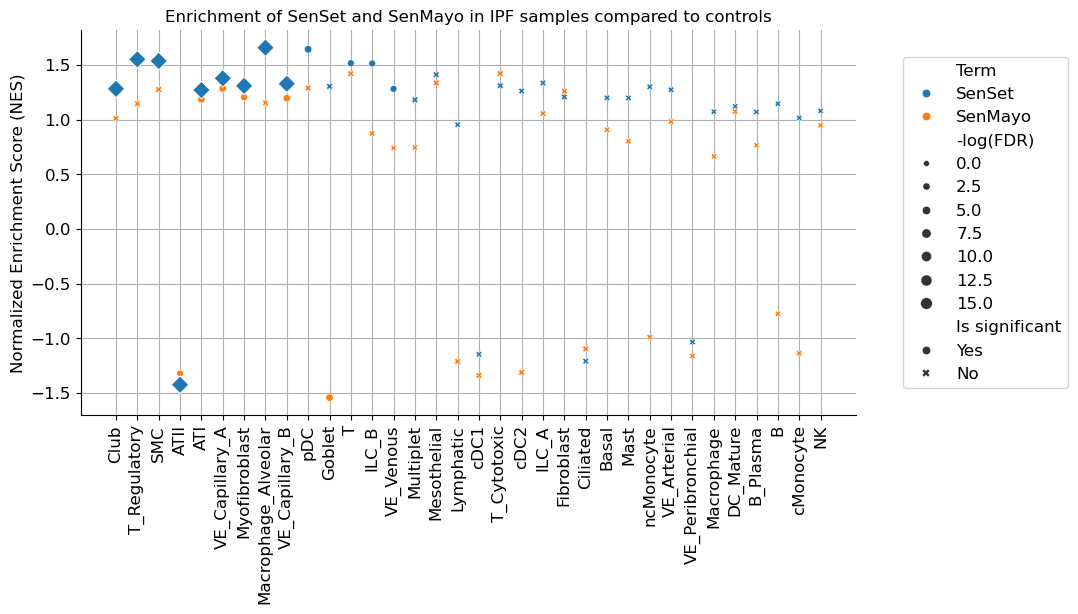

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(
    cell_type_to_res_ss,
    y="NES",
    x="Cell Type",
    hue='Term',
    hue_order=['SenSet', 'SenMayo'],
    size='-log(FDR)',
    # style='P=0',
    style='Is significant',
    # style_order=['No', 'Yes'],
    style_order=['Yes', 'No'],
    # palette=['#1461f0', '#f77f00'],
    # palette=[gene_set_to_color['SenSet'], gene_set_to_color['SenMayo']],
    ax=ax,
)

sns.scatterplot(
    cell_type_to_res_ss[cell_type_to_res_ss['FDR q-val'] == 1e-15],
    y="NES",
    x="Cell Type",
    hue='Term',
    hue_order=['SenSet', 'SenMayo'],
    style='Cell Type',
    s=80,
    # size='-log(FDR)',
    markers=['D'],
    # size='-log(FDR) (mod)',
    # palette=[gene_set_to_color['SenSet'], gene_set_to_color['SenMayo']],
    legend=False,
)

ax.set_axisbelow(True)
ax.grid(zorder=0)
ax.set_ylabel('Normalized Enrichment Score (NES)', fontsize=12)
ax.set_xlabel('', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_title(r"Enrichment of SenSet and SenMayo in IPF samples compared to controls", fontsize=12)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
sns.despine(ax=ax)

ax.tick_params(axis='x', rotation=90)

artist.savefig(root / 'IPF-vs-Controls.pdf')

In [14]:
_short = cell_type_to_res_ss[cell_type_to_res_ss['Cell Type'] == 'Goblet']
genes_senmayo = _short.iloc[0]['Lead_genes'].split(';')
genes_senset = _short.iloc[1]['Lead_genes'].split(';')

In [18]:
len(genes_senmayo), len(genes_senset)

(25, 33)

In [26]:
len(set(genes_senset) - set(SNC.SenMayo))

25

In [23]:
np.intersect1d(genes_senset, SNC.SenMayo).shape

(8,)

In [17]:
np.intersect1d(genes_senmayo, SNC.SenSet)

array(['AREG', 'CXCL2', 'CXCL8', 'EDN1', 'ETS2', 'IL18', 'IL6ST', 'PLAUR'],
      dtype='<U8')

In [15]:
genes_senmayo

['CXCL8',
 'CXCL1',
 'CXCL2',
 'CXCL3',
 'CCL20',
 'EDN1',
 'IL6',
 'ITGA2',
 'PLAUR',
 'VEGFA',
 'ETS2',
 'GDF15',
 'SERPINB4',
 'IL6ST',
 'AXL',
 'IL18',
 'ICAM1',
 'PLAU',
 'IGFBP5',
 'IL7',
 'SEMA3F',
 'AREG',
 'PAPPA',
 'CXCL10',
 'PIGF']

In [13]:
goblet_results = cell_type_to_res[cell_type_to_res['Cell Type'] == 'Goblet']
goblet_results.to_csv('goblet-ipf-senmayo-senset.csv')

In [19]:
goblet_results

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,Cell Type,Disease,-log(FDR),Is significant
0,prerank,SenMayo,-0.514443,-1.683573,0.0,0.0,0.0,22/114,4.21%,CXCL8;CXCL1;CXCL2;CXCL3;EDN1;VEGFA;ITGA2;IL6;C...,Goblet,IPF,10.000000,Yes
1,prerank,SenSet,0.540748,1.384351,0.024249,0.022857,0.038,33/100,5.38%,CTNNB1;VIM;LMNA;ID1;FOS;GSN;RHOB;JUN;CD9;TMSB4...,Goblet,IPF,1.640978,Yes
